# Manufacturing Threshold Modeling

## Abstract

This analysis documents my analysis of the SOC range implications of assuming a VHA threshold equal to 1.2146. The concern was that the SOC range will be excessive (>10%). I am using a Monte Carlo analysis here to estimate the actual SOC range based on the sampling the empirical distribution of the HPM10 ratio error. 

I am guessing at the distribution of the A/D converter errors. I have seen data that indicates something in the range of 5 mV to 10 mV with a normal distribution. Note that I am ignoring random quantization errors because those can be minimized by averaging.



In [127]:
# Load in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

VHA=1.2146 # This value is too low. It probably should be 1.24 V

## Read in the Z22A SOC Curve

This SOC curve assumes a minimum operating voltage for the Z22A based on the wireless circuit. 

Text(0, 0.5, 'SOC (%)')

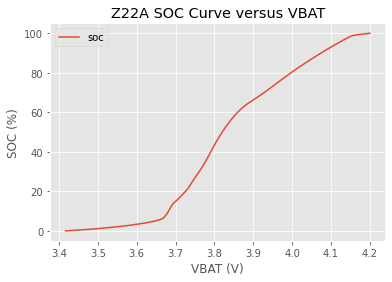

In [128]:
dfSOC=pd.read_csv("Z22A.csv",sep="\t")
dfSOC['SOC'] = dfSOC['SOC'].str.rstrip('%').astype('float') / 100.0
SOCZ22A = scipy.interpolate.interp1d(dfSOC.VBAT, dfSOC.SOC)

x=np.linspace(3.417, 4.2, num=100)
z22A_soc_table = pd.DataFrame({'vbat':x,'soc':100*SOCZ22A(x)})
z22A_soc_table.plot.line('vbat','soc')
plt.title("Z22A SOC Curve versus VBAT")
plt.xlabel("VBAT (V)")
plt.ylabel("SOC (%)")

## Read in the Empirical Ratio Data

Here is a sample of 6103 HPM10 ratios measured by production. Observe that while the bulk of HPM10 ratios are tightly bunched, there are a small number that are significantly different.

In [129]:
df = pd.read_csv("RawRatio.csv")
display(df)

,Ratio
0,0.327312
1,0.328617
2,0.329617
3,0.331623
4,0.331720
...,...
6098,0.332991
6099,0.332991
6100,0.332991
6101,0.333009


Minimum ratio is 0.327312.
Maximum ratio is 0.333018.
Range is 0.005706.


array([[<AxesSubplot:title={'center':'Ratio'}>]], dtype=object)

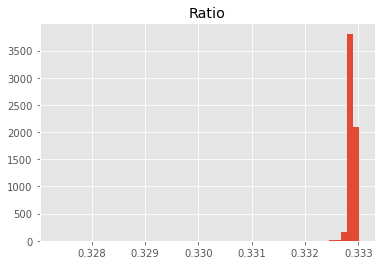

In [130]:
print(f'Minimum ratio is {df.Ratio.min():.6f}.')
print(f'Maximum ratio is {df.Ratio.max():.6f}.')
print(f'Range is {df.Ratio.max()-df.Ratio.min():.6f}.')
plt.style.use("ggplot")
df.hist(bins=50)

## Compute the Battery Voltage Under Ratio and A/D Variation

VBAT minimum is 3.6225V.
VBAT maximum is 3.7207V.
VBAT range is 0.0982V.
Notice how the range is quite a bit wider than where the bulk of the distribution resides.


Text(0, 0.5, 'Number of Units')

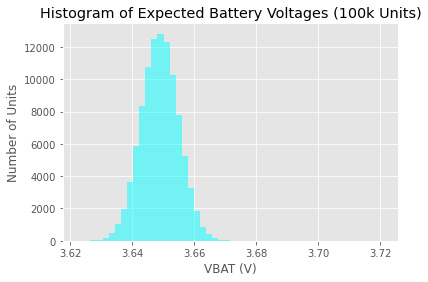

In [131]:
ratio=df.Ratio.sample(100_000, replace=True)
lsad=np.random.normal(loc=0,scale=0.002,size=100_000)
vbat = (VHA+lsad)/ratio
print(f'VBAT minimum is {vbat.min():.4f}V.')
print(f'VBAT maximum is {vbat.max():.4f}V.')
print(f'VBAT range is {vbat.max()-vbat.min():.4f}V.')
print(f'Notice how the range is quite a bit wider than where the bulk of the distribution resides.')
plt.hist(vbat.values, color='cyan', alpha=0.5, bins=50)
plt.title("Histogram of Expected Battery Voltages (100k Units)")
plt.xlabel("VBAT (V)")
plt.ylabel("Number of Units")

Text(0, 0.5, 'Number of Units')

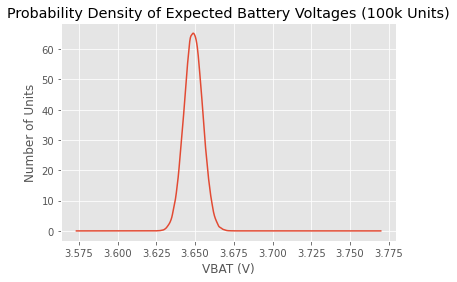

In [132]:
vbat.plot.kde()
plt.title("Probability Density of Expected Battery Voltages (100k Units)")
plt.xlabel("VBAT (V)")
plt.ylabel("Number of Units")

## Compute SOC Variation Distribution

We now see how uncertainty in VBAT manifests in an uncertainty in battery SOC.

Assuming we will allow 1 out of 500 fail for SOC, we can compute the SOC range as follows.

In [133]:
vTLow=np.quantile(vbat, q=0.001)
vTHigh=np.quantile(vbat,q=0.999)
print(f'Assume we set a VHA side threshold of {VHA:.4f}V.')
print(f'This VHA will map to a battery voltage range of {vTLow:.4f}V to {vTHigh:.4f}V.')
print(f'These battery voltage represent a SOC range of {SOCZ22A(vTLow):.1%} to {SOCZ22A(vTHigh):.1%}.')


Assume we set a VHA side threshold of 1.2146V.
This VHA will map to a battery voltage range of 3.6306V to 3.6694V.
These battery voltage represent a SOC range of 4.3% to 6.7%.


SOC minimum is 4.0%.
SOC maximum is 19.0%.
SOC range is 14.9%.


Text(0, 0.5, 'Number of Units')

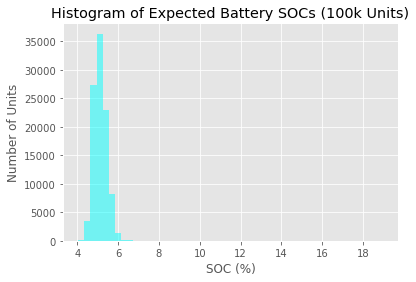

In [134]:
# Given vbat values, I can generate the expected SOC values.
socz = SOCZ22A(vbat)
print(f'SOC minimum is {socz.min():.1%}.')
print(f'SOC maximum is {socz.max():.1%}.')
print(f'SOC range is {socz.max()-socz.min():.1%}.')
plt.hist(100*socz, color='cyan', alpha=0.5,bins=50)
plt.title("Histogram of Expected Battery SOCs (100k Units)")
plt.xlabel("SOC (%)")
plt.ylabel("Number of Units")


Text(0, 0.5, 'Probability')

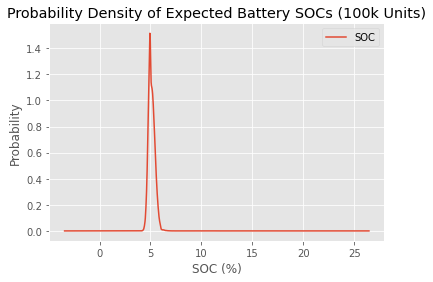

In [135]:
sz = pd.DataFrame(socz,columns=['SOC'])
(100*sz).plot.kde()
plt.title("Probability Density of Expected Battery SOCs (100k Units)")
plt.xlabel("SOC (%)")
plt.ylabel("Probability")

The issue with the Z22A is that the threshold is set on the portion of the SOC curve that is very flat.

## Same Analysis for Accu60

Let's examine what happens when you use the same threshold with the Accu60/94 SOC.

### Read in Accu60 SOC

Text(0, 0.5, 'SOC (%)')

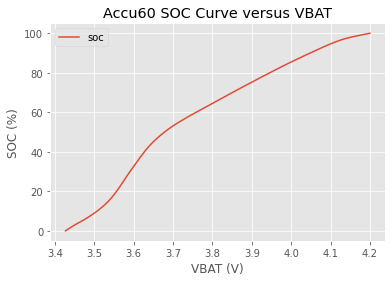

In [136]:
dfSOC=pd.read_csv("Accu60.csv",sep="\t")
dfSOC['SOC'] = dfSOC['SOC'].str.rstrip('%').astype('float') / 100.0
SOC60 = scipy.interpolate.interp1d(dfSOC.VBAT, dfSOC.SOC)
x=np.linspace(3.427, 4.2, num=100)
Accu60_soc_table = pd.DataFrame({'vbat':x,'soc':100*SOC60(x)})
Accu60_soc_table.plot.line('vbat','soc')
plt.title("Accu60 SOC Curve versus VBAT")
plt.xlabel("VBAT (V)")
plt.ylabel("SOC (%)")

### Compute the SOC Range 

In [137]:
print(f'Assume we set a VHA side threshold of {VHA:.4f}V.')
print(f'This VHA will map to a battery voltage range of {vTLow:.4f}V to {vTHigh:.4f}V.')
print(f'These battery voltage represent a SOC range of {SOC60(vTLow):.1%} to {SOC60(vTHigh):.1%}.')

Assume we set a VHA side threshold of 1.2146V.
This VHA will map to a battery voltage range of 3.6306V to 3.6694V.
These battery voltage represent a SOC range of 40.9% to 48.6%.


### Compute the SOC Distribution

The Varta batteries have a much higher SOC for a given threshold voltage.

SOC minimum is 38.8%.
SOC maximum is 55.7%.
SOC range is 16.9%.


Text(0, 0.5, 'Number of Units')

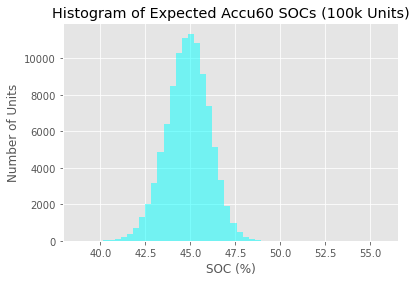

In [138]:
soca = SOC60(vbat)
print(f'SOC minimum is {soca.min():.1%}.')
print(f'SOC maximum is {soca.max():.1%}.')
print(f'SOC range is {soca.max()-soca.min():.1%}.')
plt.hist(100*soca, color='cyan', alpha=0.5,bins=50)
plt.title("Histogram of Expected Accu60 SOCs (100k Units)")
plt.xlabel("SOC (%)")
plt.ylabel("Number of Units")

Text(0, 0.5, 'Probability')

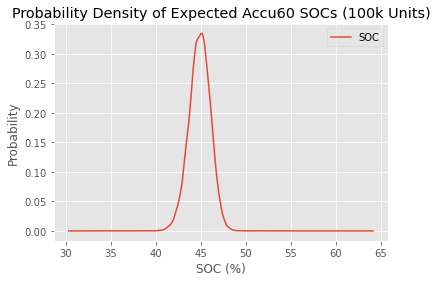

In [139]:
sa = pd.DataFrame(100*soca,columns=['SOC'])
sa.plot.kde()
plt.title("Probability Density of Expected Accu60 SOCs (100k Units)")
plt.xlabel("SOC (%)")
plt.ylabel("Probability")